# FluxInfer RCA method

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

In [3]:
import sys
sys.path.append('../')
from tsdr import tsdr
from diagnoser import diag
from eval import groundtruth

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
from meltria import loader

metrics_files = !find /datasets/argowf-chaos-rq54b/ -type f -name "*.json" | head -n 3
dataset_generator = loader.load_dataset_as_generator(metrics_files, target_metric_types={
        "containers": True,
        "services": True,
        "nodes": True,
        "middlewares": True,
    },
    num_datapoints=120,
)
records = [r for rec in dataset_generator for r in rec]

In [5]:
import networkx as nx
from multiprocessing import cpu_count

In [6]:
record_and_reduced_df: list = []
for record in records:
    # run tsdr
    reducer = tsdr.Tsdr("residual_integral", **{
        "step1_residual_integral_threshold": 20,
        "step1_residual_integral_change_start_point": False,
        "step1_residual_integral_change_start_point_n_sigma": 3,
        "step2_clustering_method_name": "dbscan",
        "step2_dbscan_min_pts": 2,
        "step2_dbscan_dist_type": 'sbd',
        "step2_dbscan_algorithm": 'hdbscan',
        "step2_clustering_series_type": 'raw',
        "step2_clustering_choice_method": 'medoid',
    })
    tsdr_stat, clustering_info, anomaly_points = reducer.run(
        X=record.data_df,
        pk=record.pk,
        max_workers=cpu_count(),
    )
    reduced_df = tsdr_stat[-1][0]
    no_clustering_reduced_df = tsdr_stat[-2][0]
    record_and_reduced_df.append((record, reduced_df, no_clustering_reduced_df))

In [7]:
from itertools import combinations
import diagnoser.metric_node as mn

def fisher_z(dm, cm, x, y) -> float:
    m = dm.shape[0]
    r = cm[x, y]
    if 1 - r == 0. or 1 + r == 0.:
        r = 1 - 1e-10
    zstat = np.sqrt(m - 3) * 0.5 * np.log((1 + r) / (1 - r))
    p_val = 2.0 * scipy.stats.norm.sf(np.absolute(zstat))
    return p_val

def build_wudg(pk, data_df: pd.DataFrame, init_graph_type="complete") -> nx.Graph:
    nodes = mn.MetricNodes.from_dataframe(data_df)
    g: nx.Graph
    match init_graph_type:
        case "complete":
            g = nx.Graph()
            for (u, v) in combinations(nodes, 2):
                g.add_edge(u, v)
        case "nw_call":
            g = diag.prepare_init_graph(nodes, pk)
        case _:
            assert False, f"Unknown init_graph_type: {init_graph_type}"

    dm = data_df.to_numpy()
    cm = np.corrcoef(dm.T)
    _g = nx.relabel_nodes(g, mapping=nodes.node_to_num)
    for (u, v) in _g.edges:
        p_val = fisher_z(dm, cm, u, v)
        _g[u][v]['weight'] = 1 / p_val if p_val != 0.0 else sys.float_info.max

    return nx.relabel_nodes(_g, mapping=nodes.num_to_node)

In [8]:
record, reduced_df, no_clustering_reduced_df = record_and_reduced_df[1]
WUDG = build_wudg(record.pk, reduced_df)

/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
  _g[u][v]['weight'] = 1 / p_val if p_val != 0.0 else sys.float_info.max


In [9]:
def nx_draw(graph: nx.Graph, ax):
    pos=nx.spring_layout(graph, weight=None)
    nx.draw_networkx(graph, pos=pos, ax=ax, font_size=8, node_size=150)
    elabels = nx.get_edge_attributes(graph, 'weight')
    for k, weight in elabels.items():
        elabels[k] = f"{weight:.2g}"
    nx.draw_networkx_edge_labels(graph, pos=pos, ax=ax, edge_labels=elabels, font_size=6)

def draw_by_graph(graphs: list[nx.Graph], suptitle: str):
    fig = plt.figure(1, figsize=(20, 20))
    fig.suptitle(suptitle)
    axs = fig.subplots(3, 2).flatten()

    for ax, g in zip(axs, sorted(graphs, key=lambda g: len(g.nodes), reverse=True)[:5]):
        pr = nx.pagerank(g, alpha=0.85) # default
        display(sorted(pr.items(), reverse=True, key=lambda x: x[1])[:5])
        nx_draw(g, ax)

# for suptitle, graphs in (("Root contained graph", root_contained_g), ("Root uncontained graph", root_uncontained_g)):
#     draw_by_graph(graphs, suptitle)

In [10]:
pr = nx.pagerank(WUDG, alpha=0.85) # default
display(sorted(pr.items(), reverse=True, key=lambda x: x[1])[:15])

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,


[(n-gke-train-ticket-01-default-pool-9df6151e-kng0_softnet_processed_total,
  0.022520559703925785),
 (m-ts-travel2-mongo_mongodb_top_readLock_count, 0.020104584436420745),
 (m-ts-basic-service_java_lang_OperatingSystem_CommittedVirtualMemorySize,
  0.01613403227843816),
 (m-ts-order-service_java_lang_ClassLoading_LoadedClassCount,
  0.015116026903206459),
 (m-ts-ui-dashboard_nginx_http_request_size_bytes, 0.013549341431549348),
 (m-ts-route-mongo_mongodb_top_readLock_count, 0.013383501275371882),
 (m-ts-ticket-office-mongo_mongodb_ss_wt_data_handle_session_sweep_attempts,
  0.011685411924610251),
 (m-ts-config-mongo_mongodb_top_readLock_count, 0.011555659456976959),
 (s-ts-price_requests_count, 0.011140901910405244),
 (m-ts-consign-mongo_mongodb_dbstats_indexSize, 0.010487491930990325),
 (m-ts-admin-basic-info-service_java_lang_Tenured_Gen_PeakUsage_used,
  0.009081534333243034),
 (m-ts-admin-travel-service_java_lang_MemoryPool_PeakUsage_used,
  0.008682658745164471),
 (m-ts-contacts-

## Evaluate by AC@k and AVG@k

In [11]:
from eval import groundtruth

True

'no:314'

c-ts-train-mongo_network_receive_bytes_total

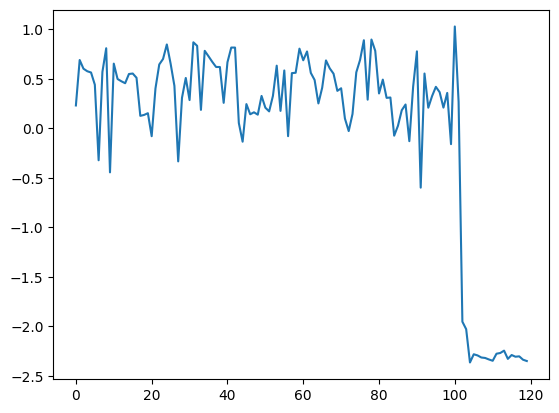

In [12]:
pr: dict[str, float] = nx.pagerank(WUDG, alpha=0.85) # default
ranked_metric_to_score: list[tuple[mn.MetricNode, float]] = sorted(pr.items(), reverse=True, key=lambda x: x[1])
ranked_metrics = mn.MetricNodes.from_list_of_metric_node([m for m, _ in ranked_metric_to_score])
ok, cause_metrics = groundtruth.check_cause_metrics(
    record.pk, ranked_metrics, chaos_type=record.chaos_type(), chaos_comp=record.chaos_comp(),
)
display(ok)
for cm in cause_metrics:
    display(f"no:{list(ranked_metrics).index(cm)}", cm)
    plt.plot(reduced_df[str(cm)].to_numpy())

## All fault cases

In [13]:
from meltria import loader

metrics_files = !find /datasets/argowf-chaos-rq54b/ -type f -name "*.json"
dataset_generator = loader.load_dataset_as_generator(metrics_files, target_metric_types={
        "containers": True,
        "services": True,
        "nodes": True,
        "middlewares": True,
    },
    num_datapoints=120,
)
records = [r for rec in dataset_generator for r in rec]

In [14]:
record_and_reduced_df: list = []
for record in records:
    # run tsdr
    reducer = tsdr.Tsdr("residual_integral", **{
        "step1_residual_integral_threshold": 20,
        "step1_residual_integral_change_start_point": False,
        "step1_residual_integral_change_start_point_n_sigma": 3,
        "step2_clustering_method_name": "dbscan",
        "step2_dbscan_min_pts": 2,
        "step2_dbscan_dist_type": 'sbd',
        "step2_dbscan_algorithm": 'hdbscan',
        "step2_clustering_series_type": 'raw',
        "step2_clustering_choice_method": 'medoid',
    })
    tsdr_stat, clustering_info, anomaly_points = reducer.run(
        X=record.data_df,
        pk=record.pk,
        max_workers=cpu_count(),
    )
    reduced_df = tsdr_stat[-1][0]
    no_clustering_reduced_df = tsdr_stat[-2][0]
    record_and_reduced_df.append((record, reduced_df, no_clustering_reduced_df))

In [15]:
# parallelize
import joblib

wudgs: list[tuple[nx.Graph, loader.DatasetRecord, pd.DataFrame, pd.DataFrame]]
wudgs = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg)(record.pk, reduced_df) for record, reduced_df, no_clustering_reduced_df in record_and_reduced_df)

/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overf

In [16]:
import joblib

prs: list[tuple[dict, loader.DatasetRecord, pd.DataFrame, pd.DataFrame]] = []
prs = joblib.Parallel(n_jobs=-1)(joblib.delayed(nx.pagerank)(wudg, alpha=0.85) for wudg in wudgs)

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,
/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,


In [17]:
from eval import validation

def check_validate_record(record) -> bool:
    return validation.check_valid_dataset(
        record, labbeling={"n_sigma_rule": {"n_sigmas": [2, 3]}}, fault_inject_time_index=99)

In [18]:
from itertools import chain

anomaly_case_sizes = len(prs)
top_k_set = range(1, 11)
ac_k: dict[int, float] = {k: 0.0 for k in top_k_set}
rank_by_case: dict[str, list[int]] = defaultdict(list)
print(len(prs), len(record_and_reduced_df))
for pr, (record, reduced_df, non_clustering_reduced_df) in zip(prs, record_and_reduced_df):
    ranked_metric_to_score: list[tuple[mn.MetricNode, float]] = sorted(pr.items(), reverse=True, key=lambda x: x[1])
    ranked_metrics = mn.MetricNodes.from_list_of_metric_node([m for m, _ in ranked_metric_to_score])
    _, cause_metrics = groundtruth.check_cause_metrics(
        record.pk, ranked_metrics, chaos_type=record.chaos_type(), chaos_comp=record.chaos_comp(),
    )
    if len(cause_metrics) == 0:
        print(f"no cause metrics: {record.chaos_case_full()}")
        continue
    rank: int = sorted([list(ranked_metrics).index(cm) for cm in cause_metrics])[0] + 1
    print(f"rank: {rank}, {record.chaos_case_full()}")
    rank_by_case[record.chaos_type()].append(rank)
    # plt.plot(reduced_df[str(cm)].to_numpy())

for k in top_k_set:
    ac_k[k] = sum([1 if rank <= k else 0 for rank in chain.from_iterable(rank_by_case.values())]) / anomaly_case_sizes
display("AC@K", ac_k)

avg_k = {}
for k in top_k_set:
    avg_k[k] = sum([ac_k[j] for j in range(1, k+1)]) / k
display("AVG@k", avg_k)

77 77
rank: 394, ts-preserve-service/pod-network-loss/0
rank: 309, ts-train-mongo/pod-network-loss/0
rank: 134, ts-price-service/pod-memory-hog/0
rank: 14, ts-travel-service/pod-cpu-hog/0
rank: 272, ts-auth-mongo/pod-memory-hog/0
rank: 6, ts-train-service/pod-memory-hog/0
rank: 3, ts-order-service/pod-cpu-hog/0
rank: 24, ts-auth-mongo/pod-cpu-hog/0
rank: 59, ts-basic-service/pod-cpu-hog/0
rank: 282, ts-train-mongo/pod-memory-hog/0
rank: 99, ts-preserve-service/pod-cpu-hog/0
rank: 348, ts-food-mongo/pod-cpu-hog/0
rank: 34, ts-price-mongo/pod-cpu-hog/0
rank: 368, ts-order-service/pod-network-loss/0
rank: 79, ts-station-service/pod-memory-hog/0
rank: 408, ts-travel2-service/pod-network-loss/0
rank: 364, ts-food-mongo/pod-network-loss/0
rank: 5, ts-food-service/pod-memory-hog/0
rank: 150, ts-travel2-service/pod-memory-hog/0
rank: 10, ts-cancel-service/pod-memory-hog/0
rank: 59, ts-payment-mongo/pod-cpu-hog/0
rank: 15, ts-basic-service/pod-memory-hog/0
rank: 366, ts-price-service/pod-networ

'AC@K'

{1: 0.012987012987012988,
 2: 0.012987012987012988,
 3: 0.025974025974025976,
 4: 0.025974025974025976,
 5: 0.03896103896103896,
 6: 0.05194805194805195,
 7: 0.05194805194805195,
 8: 0.07792207792207792,
 9: 0.09090909090909091,
 10: 0.11688311688311688}

'AVG@k'

{1: 0.012987012987012988,
 2: 0.012987012987012988,
 3: 0.017316017316017316,
 4: 0.01948051948051948,
 5: 0.023376623376623377,
 6: 0.02813852813852814,
 7: 0.03153988868274583,
 8: 0.037337662337662336,
 9: 0.043290043290043295,
 10: 0.05064935064935065}

### Evaluation with service granulally

In [19]:
from itertools import chain

anomaly_case_sizes = len(prs)
top_k_set = range(1, 11)
ac_k: dict[int, float] = {k: 0.0 for k in top_k_set}
rank_by_case: dict[str, list[int]] = defaultdict(list)
print(len(prs), len(record_and_reduced_df))
for pr, (record, reduced_df, non_clustering_reduced_df) in zip(prs, record_and_reduced_df):
    chaos_service: str = record.chaos_comp().removesuffix("-service").removesuffix("-mongo")
    ranked_metric_to_score: list[tuple[mn.MetricNode, float]] = sorted(pr.items(), reverse=True, key=lambda x: x[1])
    rank: int = sorted([i+1 for i, (m, _) in enumerate(ranked_metric_to_score) if m.comp.startswith(chaos_service)])[0]
    print(f"rank: {rank}, {record.chaos_case_full()}")
    rank_by_case[record.chaos_type()].append(rank)
    # plt.plot(reduced_df[str(cm)].to_numpy())

for k in top_k_set:
    ranks = chain.from_iterable(rank_by_case.values())
    ac_k[k] = sum([1 if rank <= k else 0 for rank in ranks]) / anomaly_case_sizes
display("AC@K", ac_k)

avg_k = {}
for k in top_k_set:
    avg_k[k] = sum([ac_k[j] for j in range(1, k+1)]) / k
display("AVG@k", avg_k)

for case, ranks in rank_by_case.items():
    _ac_k, _avg_k = {}, {}
    for k in top_k_set:
        _ac_k[k] = sum([1 if rank <= k else 0 for rank in ranks]) / len(ranks)
        _avg_k[k] = sum([_ac_k[j] for j in range(1, k+1)]) / k
    display(f"{case}:AC@K", _ac_k)
    display(f"{case}:AVG@K", _avg_k)

77 77
rank: 280, ts-preserve-service/pod-network-loss/0
rank: 56, ts-train-mongo/pod-network-loss/0
rank: 14, ts-price-service/pod-memory-hog/0
rank: 12, ts-travel-service/pod-cpu-hog/0
rank: 20, ts-auth-mongo/pod-memory-hog/0
rank: 5, ts-train-service/pod-memory-hog/0
rank: 1, ts-order-service/pod-cpu-hog/0
rank: 24, ts-auth-mongo/pod-cpu-hog/0
rank: 3, ts-basic-service/pod-cpu-hog/0
rank: 3, ts-train-mongo/pod-memory-hog/0
rank: 19, ts-preserve-service/pod-cpu-hog/0
rank: 1, ts-food-mongo/pod-cpu-hog/0
rank: 34, ts-price-mongo/pod-cpu-hog/0
rank: 15, ts-order-service/pod-network-loss/0
rank: 3, ts-station-service/pod-memory-hog/0
rank: 66, ts-travel2-service/pod-network-loss/0
rank: 4, ts-food-mongo/pod-network-loss/0
rank: 1, ts-food-service/pod-memory-hog/0
rank: 5, ts-travel2-service/pod-memory-hog/0
rank: 10, ts-cancel-service/pod-memory-hog/0
rank: 53, ts-payment-mongo/pod-cpu-hog/0
rank: 5, ts-basic-service/pod-memory-hog/0
rank: 12, ts-price-service/pod-network-loss/0
rank: 81

'AC@K'

{1: 0.09090909090909091,
 2: 0.09090909090909091,
 3: 0.16883116883116883,
 4: 0.18181818181818182,
 5: 0.24675324675324675,
 6: 0.3246753246753247,
 7: 0.3246753246753247,
 8: 0.35064935064935066,
 9: 0.36363636363636365,
 10: 0.4155844155844156}

'AVG@k'

{1: 0.09090909090909091,
 2: 0.09090909090909091,
 3: 0.11688311688311688,
 4: 0.13311688311688313,
 5: 0.15584415584415584,
 6: 0.183982683982684,
 7: 0.20408163265306123,
 8: 0.2224025974025974,
 9: 0.23809523809523808,
 10: 0.2558441558441559}

'pod-network-loss:AC@K'

{1: 0.07692307692307693,
 2: 0.07692307692307693,
 3: 0.11538461538461539,
 4: 0.15384615384615385,
 5: 0.15384615384615385,
 6: 0.19230769230769232,
 7: 0.19230769230769232,
 8: 0.23076923076923078,
 9: 0.23076923076923078,
 10: 0.23076923076923078}

'pod-network-loss:AVG@K'

{1: 0.07692307692307693,
 2: 0.07692307692307693,
 3: 0.08974358974358976,
 4: 0.10576923076923078,
 5: 0.11538461538461539,
 6: 0.12820512820512822,
 7: 0.13736263736263737,
 8: 0.14903846153846154,
 9: 0.1581196581196581,
 10: 0.1653846153846154}

'pod-memory-hog:AC@K'

{1: 0.07692307692307693,
 2: 0.07692307692307693,
 3: 0.23076923076923078,
 4: 0.23076923076923078,
 5: 0.38461538461538464,
 6: 0.46153846153846156,
 7: 0.46153846153846156,
 8: 0.46153846153846156,
 9: 0.5,
 10: 0.6153846153846154}

'pod-memory-hog:AVG@K'

{1: 0.07692307692307693,
 2: 0.07692307692307693,
 3: 0.12820512820512822,
 4: 0.15384615384615385,
 5: 0.2,
 6: 0.2435897435897436,
 7: 0.27472527472527475,
 8: 0.29807692307692313,
 9: 0.32051282051282054,
 10: 0.35000000000000003}

'pod-cpu-hog:AC@K'

{1: 0.12,
 2: 0.12,
 3: 0.16,
 4: 0.16,
 5: 0.2,
 6: 0.32,
 7: 0.32,
 8: 0.36,
 9: 0.36,
 10: 0.4}

'pod-cpu-hog:AVG@K'

{1: 0.12,
 2: 0.12,
 3: 0.13333333333333333,
 4: 0.14,
 5: 0.152,
 6: 0.18000000000000002,
 7: 0.2,
 8: 0.22000000000000003,
 9: 0.23555555555555557,
 10: 0.252}

### WUDG with CI edge cut

In [20]:
# parallelize
import joblib

wudgs: list[tuple[nx.Graph, loader.DatasetRecord, pd.DataFrame, pd.DataFrame]]
wudgs = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg)(record.pk, reduced_df, init_graph_type="nw_call") for record, reduced_df, no_clustering_reduced_df in record_and_reduced_df)

/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overflow encountered in double_scalars
/tmp/ipykernel_417947/717067231.py:31: RuntimeWarning: overf

In [21]:
prs: list[tuple[dict, loader.DatasetRecord, pd.DataFrame, pd.DataFrame]] = []
prs = joblib.Parallel(n_jobs=-1)(joblib.delayed(nx.pagerank)(wudg, alpha=0.85) for wudg in wudgs)

In [22]:
from itertools import chain

anomaly_case_sizes = len(prs)
top_k_set = range(1, 11)
ac_k: dict[int, float] = {k: 0.0 for k in top_k_set}
rank_by_case: dict[str, list[int]] = defaultdict(list)
print(len(prs), len(record_and_reduced_df))
for pr, (record, reduced_df, non_clustering_reduced_df) in zip(prs, record_and_reduced_df):
    chaos_service: str = record.chaos_comp().removesuffix("-service").removesuffix("-mongo")
    ranked_metric_to_score: list[tuple[mn.MetricNode, float]] = sorted(pr.items(), reverse=True, key=lambda x: x[1])
    ranked_service = dict.fromkeys([m.comp.removesuffix("-service").removesuffix("-mongo") for m, _ in ranked_metric_to_score])
    ranked_service = [s for s in ranked_service if not s.startswith("gke-")]
    # ranks_with_service: int = sorted([(i+1, ) for i, (m, _) in enumerate(ranked_metric_to_score) if m.comp.startswith(chaos_service)])
    rank: int = sorted([i+1 for i, service in enumerate(ranked_service) if service == chaos_service])[0]
    print(f"rank: {rank}, {record.chaos_case_full()}")
    rank_by_case[record.chaos_type()].append(rank)
    # plt.plot(reduced_df[str(cm)].to_numpy())

for k in top_k_set:
    ranks = chain.from_iterable(rank_by_case.values())
    ac_k[k] = sum([1 if rank <= k else 0 for rank in ranks]) / anomaly_case_sizes
display("AC@K", ac_k)

avg_k = {}
for k in top_k_set:
    avg_k[k] = sum([ac_k[j] for j in range(1, k+1)]) / k
display("AVG@k", avg_k)

for case, ranks in rank_by_case.items():
    _ac_k, _avg_k = {}, {}
    for k in top_k_set:
        _ac_k[k] = sum([1 if rank <= k else 0 for rank in ranks]) / len(ranks)
        _avg_k[k] = sum([_ac_k[j] for j in range(1, k+1)]) / k
    display(f"{case}:AC@K", _ac_k)
    display(f"{case}:AVG@K", _avg_k)

77 77
rank: 4, ts-preserve-service/pod-network-loss/0
rank: 4, ts-train-mongo/pod-network-loss/0
rank: 8, ts-price-service/pod-memory-hog/0
rank: 7, ts-travel-service/pod-cpu-hog/0
rank: 23, ts-auth-mongo/pod-memory-hog/0
rank: 9, ts-train-service/pod-memory-hog/0
rank: 1, ts-order-service/pod-cpu-hog/0
rank: 4, ts-auth-mongo/pod-cpu-hog/0
rank: 2, ts-basic-service/pod-cpu-hog/0
rank: 13, ts-train-mongo/pod-memory-hog/0
rank: 1, ts-preserve-service/pod-cpu-hog/0
rank: 10, ts-food-mongo/pod-cpu-hog/0
rank: 1, ts-price-mongo/pod-cpu-hog/0
rank: 7, ts-order-service/pod-network-loss/0
rank: 7, ts-station-service/pod-memory-hog/0
rank: 24, ts-travel2-service/pod-network-loss/0
rank: 24, ts-food-mongo/pod-network-loss/0
rank: 5, ts-food-service/pod-memory-hog/0
rank: 6, ts-travel2-service/pod-memory-hog/0
rank: 5, ts-cancel-service/pod-memory-hog/0
rank: 21, ts-payment-mongo/pod-cpu-hog/0
rank: 4, ts-basic-service/pod-memory-hog/0
rank: 4, ts-price-service/pod-network-loss/0
rank: 12, ts-tra

'AC@K'

{1: 0.07792207792207792,
 2: 0.1038961038961039,
 3: 0.15584415584415584,
 4: 0.2727272727272727,
 5: 0.36363636363636365,
 6: 0.42857142857142855,
 7: 0.5454545454545454,
 8: 0.5844155844155844,
 9: 0.6493506493506493,
 10: 0.6623376623376623}

'AVG@k'

{1: 0.07792207792207792,
 2: 0.09090909090909091,
 3: 0.11255411255411256,
 4: 0.1525974025974026,
 5: 0.19480519480519481,
 6: 0.23376623376623376,
 7: 0.2782931354359926,
 8: 0.31655844155844154,
 9: 0.35353535353535354,
 10: 0.38441558441558443}

'pod-network-loss:AC@K'

{1: 0.038461538461538464,
 2: 0.038461538461538464,
 3: 0.038461538461538464,
 4: 0.19230769230769232,
 5: 0.2692307692307692,
 6: 0.34615384615384615,
 7: 0.4230769230769231,
 8: 0.46153846153846156,
 9: 0.5384615384615384,
 10: 0.5384615384615384}

'pod-network-loss:AVG@K'

{1: 0.038461538461538464,
 2: 0.038461538461538464,
 3: 0.038461538461538464,
 4: 0.07692307692307693,
 5: 0.11538461538461538,
 6: 0.15384615384615383,
 7: 0.1923076923076923,
 8: 0.22596153846153844,
 9: 0.26068376068376065,
 10: 0.28846153846153844}

'pod-memory-hog:AC@K'

{1: 0.038461538461538464,
 2: 0.07692307692307693,
 3: 0.19230769230769232,
 4: 0.2692307692307692,
 5: 0.46153846153846156,
 6: 0.5769230769230769,
 7: 0.7307692307692307,
 8: 0.7692307692307693,
 9: 0.8461538461538461,
 10: 0.8461538461538461}

'pod-memory-hog:AVG@K'

{1: 0.038461538461538464,
 2: 0.057692307692307696,
 3: 0.10256410256410257,
 4: 0.14423076923076922,
 5: 0.20769230769230768,
 6: 0.2692307692307692,
 7: 0.33516483516483514,
 8: 0.38942307692307687,
 9: 0.44017094017094016,
 10: 0.4807692307692307}

'pod-cpu-hog:AC@K'

{1: 0.16,
 2: 0.2,
 3: 0.24,
 4: 0.36,
 5: 0.36,
 6: 0.36,
 7: 0.48,
 8: 0.52,
 9: 0.56,
 10: 0.6}

'pod-cpu-hog:AVG@K'

{1: 0.16,
 2: 0.18,
 3: 0.19999999999999998,
 4: 0.24,
 5: 0.26399999999999996,
 6: 0.27999999999999997,
 7: 0.30857142857142855,
 8: 0.33499999999999996,
 9: 0.36,
 10: 0.384}

### Evaluate only phase 1

In [ ]:
import joblib

wudgs: list[tuple[nx.Graph, loader.DatasetRecord, pd.DataFrame, pd.DataFrame]]
wudgs = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg)(record.pk, no_clustering_reduced_df, init_graph_type="nw_call") for record, reduced_df, no_clustering_reduced_df in record_and_reduced_df)

In [ ]:
import joblib

wudgs: list[tuple[nx.Graph, loader.DatasetRecord, pd.DataFrame, pd.DataFrame]]
wudgs = joblib.Parallel(n_jobs=-1)(joblib.delayed(build_wudg)(record.pk, no_clustering_reduced_df, init_graph_type="nw_call") for record, reduced_df, no_clustering_reduced_df in record_and_reduced_df)

In [ ]:
prs: list[tuple[dict, loader.DatasetRecord, pd.DataFrame, pd.DataFrame]] = []
prs = joblib.Parallel(n_jobs=-1)(joblib.delayed(nx.pagerank)(wudg, alpha=0.85) for wudg in wudgs)

In [ ]:
from itertools import chain

anomaly_case_sizes = len(prs)
top_k_set = range(1, 11)
ac_k: dict[int, float] = {k: 0.0 for k in top_k_set}
rank_by_case: dict[str, list[int]] = defaultdict(list)
print(len(prs), len(record_and_reduced_df))
for pr, (record, reduced_df, non_clustering_reduced_df) in zip(prs, record_and_reduced_df):
    chaos_service: str = record.chaos_comp().removesuffix("-service").removesuffix("-mongo")
    ranked_metric_to_score: list[tuple[mn.MetricNode, float]] = sorted(pr.items(), reverse=True, key=lambda x: x[1])
    rank: int = sorted([i+1 for i, (m, _) in enumerate(ranked_metric_to_score) if m.comp.startswith(chaos_service)])[0]
    print(f"rank: {rank}, {record.chaos_case_full()}")
    rank_by_case[record.chaos_type()].append(rank)
    # plt.plot(reduced_df[str(cm)].to_numpy())

for k in top_k_set:
    ranks = chain.from_iterable(rank_by_case.values())
    ac_k[k] = sum([1 if rank <= k else 0 for rank in ranks]) / anomaly_case_sizes
display("AC@K", ac_k)

avg_k = {}
for k in top_k_set:
    avg_k[k] = sum([ac_k[j] for j in range(1, k+1)]) / k
display("AVG@k", avg_k)

for case, ranks in rank_by_case.items():
    _ac_k, _avg_k = {}, {}
    for k in top_k_set:
        _ac_k[k] = sum([1 if rank <= k else 0 for rank in ranks]) / len(ranks)
        _avg_k[k] = sum([_ac_k[j] for j in range(1, k+1)]) / k
    display(f"{case}:AC@K", _ac_k)